<a href="https://colab.research.google.com/github/AlkaidCheng/GSOC_MLHEP/blob/master/Feature_Updates_Jul_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install quple

     |████████████████████████████████| 40kB 2.5MB/s 
     |████████████████████████████████| 421.8MB 35kB/s 
     |████████████████████████████████| 3.9MB 21.0MB/s 
     |████████████████████████████████| 1.4MB 33.7MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 450kB 25.8MB/s 
     |████████████████████████████████| 3.9MB 41.8MB/s 
     |████████████████████████████████| 163kB 36.0MB/s 
     |████████████████████████████████| 5.3MB 27.3MB/s 
     |████████████████████████████████| 112kB 39.8MB/s 
     |████████████████████████████████| 133kB 41.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=a01a7b9d39f189a6a32fcbd71bef6ab315af9f45a1f69d4fbdf500ca4e419db8
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for pathos: filename=pathos-0.2.5-cp36-none-any.whl size=77577 sha256=bc096d9841d8118828eb63e66f6a14f1b961dcc1bfae713c2

#Updates
- Allow unflattening the parameter symbols in a parameterised circuit
- Added more useful properties and helper functions to the QuantumCircuit and ParameterisedCircuit instance
 - new properties:
   - symbols : show a list of unresolved symbols in a circuit
   - parameters (for ParameterisedCircuit only): show a list of symbols in the parameterised circuit that is not affected by the action of flattening.
   - readout_qubit: the readout qubit of a circuit
 - new helper functions:
   - replace_symbol_in_op: replaces the free symbol in a gate operation by a new one
   - pqc_symbol_map: map the old symbols in a pqc with new ones
   - get_circuit_symbols: get all unresolved symbols in a circuit
   - get_circuit_qubits: get the qubits associated with a circuit
- Added support for adding readout qubits for ParameterisedCircuit instance
- Improved implementation of merging parameterised circuits 
 - Fixes problem with flattened circuits (originally it will replace the entire flattened expression with a new symbol but now the symbol inside the flattened expression will be replaced)
 - Native implementation of the merge function for ParameterisedCircuit instance
- Improved implementation of ParameterisedCircuit class
  - Allow support for adding rotation layers and entanglement layers after initialization
  - Allow merging with another ParameterisedCircuit instance
  - Simplified the code for getting new parameters in the circuit
- Improved implementation of VQC class (Variational Quantum Classifier)
 - allow one to enable or disable trainable parameters in the output dense layer
 - allow custom readout instead of measuring all qubits
- Implemented a custom VQC logger

In [2]:
#import dependencies
import numpy as np
import tensorflow as tf
import quple 
from quple import QuantumCircuit, ParameterisedCircuit
from quple.data_encoding import FirstOrderExpansion, SecondOrderExpansion
from quple.trial_wavefunction import EfficientSU2, RealAmplitudes, ExcitationPreserving

### Unflatten a circuit

Usually a circuit will have its parameterised gate expressions flattened to avoid slow parsing from sympy.

This can be done by the `QuantumCircuit.flatten()` method. 

It is natural to undo this action by applying `QuantumCircuit.unflatten()` method.

In [5]:
# First construct an encoding circuit of 5 qubits
n_qubit = 5
cq = SecondOrderExpansion(n_qubit)
# Observe that the parameters have been flattened to the form <....>
print(cq)

                                                                                  ┌──┐                                                 ┌─────────────────┐                                  ┌──┐                      ┌─────────────────┐                                                                                                                                    ┌──┐                                                 ┌─────────────────┐                                  ┌──┐                      ┌─────────────────┐
(0, 0): ───H───Rz(pi*x_0)───@──────────────────────@───@──────────────────────@────@────────────────────────@───@───────────────────────@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*x_0)───@──────────────────────@───@──────────────────────@────@────────────────────────@───@───────────────────────@───────────────────────────────────────────────────────────────

In [6]:
# Unflatten a circuit
print('circuit before flattening')
cq.unflatten()
print(cq)
# flatten it back
cq.flatten()
print('circuit after flattening')
print(cq)

circuit before flattening
                                                                              ┌──┐                                             ┌───────────────┐                                ┌──┐                    ┌───────────────┐                                                                                                                            ┌──┐                                             ┌───────────────┐                                ┌──┐                    ┌───────────────┐
(0, 0): ───H───Rz(pi*x_0)───@────────────────────@───@────────────────────@────@──────────────────────@───@─────────────────────@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*x_0)───@────────────────────@───@────────────────────@────@──────────────────────@───@─────────────────────@─────────────────────────────────────────────────────────────────────────────────────────────────────

## Useful properties and helper functions to the `quple.QuantumCircuit` and `quple.ParameterisedCircuit` instance

In [7]:
# get the symbols inside a circuit
print(cq)
print('Symbols after flattening:')
print(cq.symbols)
print(cq)
print(cq.symbols)
print('Symbols before flattening')
cq.unflatten()

                                                                                  ┌──┐                                                 ┌─────────────────┐                                  ┌──┐                      ┌─────────────────┐                                                                                                                                    ┌──┐                                                 ┌─────────────────┐                                  ┌──┐                      ┌─────────────────┐
(0, 0): ───H───Rz(pi*x_0)───@──────────────────────@───@──────────────────────@────@────────────────────────@───@───────────────────────@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*x_0)───@──────────────────────@───@──────────────────────@────@────────────────────────@───@───────────────────────@───────────────────────────────────────────────────────────────

In [8]:
# construct a quple.ParameterisedCircuit instance
pqc = ParameterisedCircuit(n_qubit, rotation_blocks=['H','RZ'], entanglement_blocks='XX')
print(pqc)
# print out the parameters in a circuit
print('parameters in pqc:')
print(pqc.parameters)
# compare with the symbols in a circuit
print('symbols in pqc:')
print(pqc.symbols)
print('notice that symbols are of string type whereas parameters are of sympy.Symbols type')

                                                                  ┌────────────────┐               ┌──────────────────┐
(0, 0): ───H───Rz(pi*<θ_0/pi>)───XX─────────XX─────────XX──────────XX─────────────────────────────────────────────────────────────────────────────
                                 │          │          │           │
(0, 1): ───H───Rz(pi*<θ_1/pi>)───XX^(θ_5)───┼──────────┼───────────┼───────XX──────────XX───────────XX────────────────────────────────────────────
                                            │          │           │       │           │            │
(0, 2): ───H───Rz(pi*<θ_2/pi>)──────────────XX^(θ_6)───┼───────────┼───────XX^(θ_9)────┼────────────┼────────XX───────────XX──────────────────────
                                                       │           │                   │            │        │            │
(0, 3): ───H───Rz(pi*<θ_3/pi>)─────────────────────────XX^(θ_7)────┼───────────────────XX^(θ_10)────┼────────XX^(θ_12)────┼───────────XX────────

In [9]:
# construct a parameterised gate operation
import cirq
import sympy as sp
gate = cirq.rz(sp.Symbol('x'))
print('Original gate operation:')
print(gate)
#replaces the free symbol in a gate operation by a new one
quple.replace_symbol_in_op(gate, sp.Symbol('x'), sp.Symbol('y'))
print('New gate operation with symbols replaced:')
print(gate)
print('------------------------------------------------------------------')
#map the old symbols in a pqc with new ones
pqc = ParameterisedCircuit(n_qubit, rotation_blocks=['RZ'], parameter_symbol='x', flatten_circuit=False)
print(pqc)
symbols_map = {symbol: sp.Symbol(symbol.name.replace('x','y'))  for symbol in pqc.parameters}
print('\nNow replace the symbols inside circuit with the following mappings:')
print(symbols_map)
print('\nThe resulting new circuit is:')
new_pqc = quple.pqc_symbol_map(pqc, symbols_map)
print(new_pqc)
print('------------------------------------------------------------------')
# get the unresolved symbols in a circuit:
print('Circuit symbols:')
print(quple.get_circuit_symbols(new_pqc))
# get the qubits associated with a circuit
print('Circuit qubits:')
print(quple.get_circuit_qubits(new_pqc))
print('------------------------------------------------------------------')

Original gate operation:
Rz(x/piπ)
New gate operation with symbols replaced:
Rz(y/piπ)
------------------------------------------------------------------
(0, 0): ───Rz(x_0)───

(0, 1): ───Rz(x_1)───

(0, 2): ───Rz(x_2)───

(0, 3): ───Rz(x_3)───

(0, 4): ───Rz(x_4)───

Now replace the symbols inside circuit with the following mappings:
{x_0: y_0, x_1: y_1, x_2: y_2, x_3: y_3, x_4: y_4}

The resulting new circuit is:
(0, 0): ───Rz(y_0)───

(0, 1): ───Rz(y_1)───

(0, 2): ───Rz(y_2)───

(0, 3): ───Rz(y_3)───

(0, 4): ───Rz(y_4)───
------------------------------------------------------------------
Circuit symbols:
['y_0', 'y_1', 'y_2', 'y_3', 'y_4']
Circuit qubits:
[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(0, 4)]
------------------------------------------------------------------


## Support for readout qubits in `quple.ParameterisedCircuit`

In [10]:
# construct a pqc
pqc = EfficientSU2(n_qubit)
print(pqc)
# add a readout qubit which entangles with all qubits via an XX gate
pqc.add_readout('XX')
print(pqc)
# add another readout qubit which entangles with all qubits via an YY gate and specify which qubit to use as readout
pqc.add_readout('YY', readout_qubit=cirq.GridQubit(-2,-2))
print(pqc)
print('The readout qubit is (only the last one is recorded)')
print(pqc.readout_qubit)

                                           ┌──┐       ┌──┐                                             ┌──┐       ┌──┐
(0, 0): ───Ry(θ_0)───Rz(θ_5)───@───@───@────@────────────────────────Ry(θ_10)───Rz(θ_15)───@───@───@────@────────────────────────
                               │   │   │    │                                              │   │   │    │
(0, 1): ───Ry(θ_1)───Rz(θ_6)───X───┼───┼────┼@────@────@─────────────Ry(θ_11)───Rz(θ_16)───X───┼───┼────┼@────@────@─────────────
                                   │   │    ││    │    │                                       │   │    ││    │    │
(0, 2): ───Ry(θ_2)───Rz(θ_7)───────X───┼────┼X────┼────┼@────@───────Ry(θ_12)───Rz(θ_17)───────X───┼────┼X────┼────┼@────@───────
                                       │    │     │    ││    │                                     │    │     │    ││    │
(0, 3): ───Ry(θ_3)───Rz(θ_8)───────────X────┼─────X────┼X────┼───@───Ry(θ_13)───Rz(θ_18)───────────X────┼─────X────┼X────┼───@───
               

## Merging parameterised circuits

In [11]:
# construct 3 different pqc
A = ParameterisedCircuit(n_qubit, copies=1, rotation_blocks=['RX'])
print('Circuit A:')
print(A)
B = ParameterisedCircuit(n_qubit, copies=1, entanglement_blocks=['CNOT'], entangle_strategy='linear')
print('Circuit B:')
print(B)
C = ParameterisedCircuit(n_qubit, copies=1, rotation_blocks=['RZ'])
print('Circuit C:')
print(C)
print('Merged Circuit (this will also unflatten the circuit')
D = quple.merge_pqc([A,B,C])
print(D)
print('------------------------------------------------------------------')
# now a more complicated circuit with complex parameterised gate
A = FirstOrderExpansion(n_qubit)
print('Circuit A:')
print(A)
B = SecondOrderExpansion(n_qubit)
print('Circuit B:')
print(B)
print('Merged Circuit:')
# merge the pqc and require the resulting circuit in terms of a new symbol x
C = quple.merge_pqc([A, B], symbol='x')
print(C)
print('------------------------------------------------------------------')
# If the circuit is a ParameterisedCircuit instance, then you can merge and modified a pqc by
A = RealAmplitudes(n_qubit)
print('Circuit A:')
print(A)
B = EfficientSU2(n_qubit)
print('Circuit B:')
print(B)
print('Merging B into A (this will update the A.parameters in A):')
A.merge(B)
print(A)

Circuit A:
(0, 0): ───Rx(pi*<θ_0/pi>)───

(0, 1): ───Rx(pi*<θ_1/pi>)───

(0, 2): ───Rx(pi*<θ_2/pi>)───

(0, 3): ───Rx(pi*<θ_3/pi>)───

(0, 4): ───Rx(pi*<θ_4/pi>)───
Circuit B:
(0, 0): ───@───────────────
           │
(0, 1): ───X───@───────────
               │
(0, 2): ───────X───@───────
                   │
(0, 3): ───────────X───@───
                       │
(0, 4): ───────────────X───
Circuit C:
(0, 0): ───Rz(pi*<θ_0/pi>)───

(0, 1): ───Rz(pi*<θ_1/pi>)───

(0, 2): ───Rz(pi*<θ_2/pi>)───

(0, 3): ───Rz(pi*<θ_3/pi>)───

(0, 4): ───Rz(pi*<θ_4/pi>)───
Merged Circuit (this will also unflatten the circuit
(0, 0): ───Rx(θ_0)───@───────────────Rz(θ_5)───
                     │
(0, 1): ───Rx(θ_1)───X───@───────────Rz(θ_6)───
                         │
(0, 2): ───Rx(θ_2)───────X───@───────Rz(θ_7)───
                             │
(0, 3): ───Rx(θ_3)───────────X───@───Rz(θ_8)───
                                 │
(0, 4): ───Rx(θ_4)───────────────X───Rz(θ_9)───
----------------------------------

## Easier construction with the `quple.ParameterisedCircuit` class

In [12]:
# define an empty ParameterisedCircuit class
pqc = ParameterisedCircuit(n_qubit)
# add a layer of H
pqc.add_rotation_layer(['H'])
print(pqc)
print('------------------------------------------------------------------')
# add another layer of Rx and Rz
pqc.add_rotation_layer(['RX','RZ'])
print(pqc)
print('------------------------------------------------------------------')
# add an entanglement layer composed of CNOT using linear entanglement
pqc.add_entanglement_layer(['CNOT'], 'linear')
print(pqc)
print('------------------------------------------------------------------')
# add an entanglement layer composed of XX using full entanglement
pqc.add_entanglement_layer(['XX'], 'full')
print(pqc)

(0, 0): ───H───

(0, 1): ───H───

(0, 2): ───H───

(0, 3): ───H───

(0, 4): ───H───
------------------------------------------------------------------
(0, 0): ───H───Rx(θ_0)───Rz(θ_5)───

(0, 1): ───H───Rx(θ_1)───Rz(θ_6)───

(0, 2): ───H───Rx(θ_2)───Rz(θ_7)───

(0, 3): ───H───Rx(θ_3)───Rz(θ_8)───

(0, 4): ───H───Rx(θ_4)───Rz(θ_9)───
------------------------------------------------------------------
(0, 0): ───H───Rx(θ_0)───Rz(θ_5)───@───────────────
                                   │
(0, 1): ───H───Rx(θ_1)───Rz(θ_6)───X───@───────────
                                       │
(0, 2): ───H───Rx(θ_2)───Rz(θ_7)───────X───@───────
                                           │
(0, 3): ───H───Rx(θ_3)───Rz(θ_8)───────────X───@───
                                               │
(0, 4): ───H───Rx(θ_4)───Rz(θ_9)───────────────X───
------------------------------------------------------------------
                                                                                   ┌───────────────

## Updates on the VQC class
- Allow explicit definition of readout qubits
- Allow turning off trainable parameters in the output dense layer


In [13]:
# download training data (hmumu 2jet)
!wget -O hmumu_2jet.tar.gz https://cernbox.cern.ch/index.php/s/frrpvyVfSPYdMSk/download
!tar -zxf hmumu_2jet.tar.gz

--2020-08-07 08:28:55--  https://cernbox.cern.ch/index.php/s/frrpvyVfSPYdMSk/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.32.38, 188.184.97.72, 128.142.32.26, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.32.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1648491 (1.6M) [application/gzip]
Saving to: ‘hmumu_2jet.tar.gz’

hmumu_2jet.tar.gz   100%[===================>]   1.57M  1.72MB/s    in 0.9s    

Last-modified header invalid -- time-stamp ignored.
2020-08-07 08:28:57 (1.72 MB/s) - ‘hmumu_2jet.tar.gz’ saved [1648491/1648491]



In [14]:
# prepare training data
data = np.load('hmumu_twojet_0719.npy')
x = data[:,:-1]
y = data[:,-1]
# let's say we want to train on a circuit with 5 qubit
n_qubit = 5
# let's say we want to train on 1000 events
n_event = 1000
# prepare data preprocessors from sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
# we apply 3 data preprocessors
# 1. PCA to reduce the dimension to 5 to fit the 5 qubit circuit
# 2. StandardScaler to standardize features by removing the mean and scaling to unit variance
# 3. MinMaxScaler to bound the data in the range [-1,+1]
preprocessors = [PCA(n_components=n_qubit, random_state=3), StandardScaler(), MinMaxScaler((-1,1))]
from quple.components.data_preparation import prepare_train_val_test
# split the data into training set, validation set and test set
x_train, x_val, x_test, y_train, y_val, y_test = prepare_train_val_test(x, y, train_size=n_event, val_size=n_event, test_size=n_event, preprocessors=preprocessors, random_state=24)

In [15]:
# let's try the first order expansion encoding circuit with depth 2
encoding_circuit = FirstOrderExpansion(feature_dimension=n_qubit, copies=2)
print(encoding_circuit)

(0, 0): ───H───Rz(pi*x_0)───H───Rz(pi*x_0)───

(0, 1): ───H───Rz(pi*x_1)───H───Rz(pi*x_1)───

(0, 2): ───H───Rz(pi*x_2)───H───Rz(pi*x_2)───

(0, 3): ───H───Rz(pi*x_3)───H───Rz(pi*x_3)───

(0, 4): ───H───Rz(pi*x_4)───H───Rz(pi*x_4)───


In [16]:
# let's try the Efficient SU2 variational circuit with depth 2
variational_circuit = EfficientSU2(n_qubit=n_qubit, copies=2)
# let's add an RZ layer to increase the number of training variables
variational_circuit.add_rotation_layer(['RZ'])
# add readout qubit and entangle it to all other qubits
variational_circuit.add_readout('XX')
print(variational_circuit)

                                             ┌──┐       ┌──┐                                             ┌──┐       ┌──┐
(-1, -1): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────XX──────────XX──────────XX──────────XX──────────XX──────────
                                                                                                                                          │           │           │           │           │
(0, 0): ─────Ry(θ_0)───Rz(θ_5)───@───@───@────@────────────────────────Ry(θ_10)───Rz(θ_15)───@───@───@────@────────────────────Rz(θ_20)───XX^(θ_25)───┼───────────┼───────────┼───────────┼───────────
                                 │   │   │    │                                              │   │   │    │                                           │           │           │           │
(0, 1): ─────Ry(θ_1)───Rz(θ_6)───X───┼───┼────┼@────@────@─────────────Ry(θ_11)───Rz(θ_16)───X───┼───┼───

In [17]:
from quple.classifiers.variational_quantum_classifier import VQC

In [18]:
# construct the vqc model
# If the readout option is ommited, all qubits will be measured by default
vqc = VQC(encoding_circuit, variational_circuit, activation='sigmoid',
          optimizer=tf.keras.optimizers.Adam(), metrics=['binary_accuracy','AUC'], loss='mse')
print(vqc.readout)

Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 30


ListWrapper([cirq.Z(cirq.GridQubit(-1, -1)), cirq.Z(cirq.GridQubit(0, 0)), cirq.Z(cirq.GridQubit(0, 1)), cirq.Z(cirq.GridQubit(0, 2)), cirq.Z(cirq.GridQubit(0, 3)), cirq.Z(cirq.GridQubit(0, 4))])


In [19]:
# now make a custom readout measurement
# also make the output dense layer weight not trainable, each weight will be 1/n_qubit by default
vqc = VQC(encoding_circuit, variational_circuit, activation='sigmoid',
          optimizer=tf.keras.optimizers.Adam(), metrics=['binary_accuracy','AUC'], loss='mse',
          readout=[variational_circuit.readout_measurement()], trainable_dense_layer=False)
print(vqc.readout)

Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 30


ListWrapper([cirq.Z(cirq.GridQubit(-1, -1))])


## The VQC Logger

The logger will save the following information:

The following will be saved to a log text file as well as a npz file
- Number of qubits
- Qubit layout
- Name of encoding circuit
- Name of encoding map
- Name of variational circuit
- Circuit parameters
- Number of parameters
- Name of Optimizer
- Name of Loss Function
- Name of Activation Function
- Name of Metrics
- Train Size
- Val Size
- Test Size
- Batch Size
- Number of Epochs
- Circuit Diagram for Encoding Circuit
- Circuit Diagram for Variational Circuit
- Losses in each epoch
- Model weights after training
- fpr for roc curve
- tpr for roc curve
- auc for roc curve

The following will be saved as a png file
- A ROC curve plot

In [20]:
from quple.classifiers.vqc_logger import VQCLogger
logger = VQCLogger()

In [21]:
# run the training, evaluation and test
vqc.run(x_train, y_train, x_val, y_val, x_test, y_test, batch_size=64, epochs=5, callbacks=[logger])

Converting circuits to tensors...
Converting circuits to tensors...
2020-08-07 08:29:17,541 [MainThread  ][INFO ]  ######## Executing VQC with the following attributes ########
2020-08-07 08:29:17,542 [MainThread  ][INFO ]  Feature Dimension: 5
2020-08-07 08:29:17,543 [MainThread  ][INFO ]  Number of Qubits: 6
2020-08-07 08:29:17,548 [MainThread  ][INFO ]  Qubit Layout: [cirq.GridQubit(-1, -1), cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(0, 4)]
2020-08-07 08:29:17,551 [MainThread  ][INFO ]  Encoding Circuit: FirstOrderExpansion
2020-08-07 08:29:17,554 [MainThread  ][INFO ]  Encoding Map: self_product
2020-08-07 08:29:17,555 [MainThread  ][INFO ]  Variational Circuit: EfficientSU2
2020-08-07 08:29:17,557 [MainThread  ][INFO ]  Circuit Parameters: ['θ_0', 'θ_1', 'θ_10', 'θ_11', 'θ_12', 'θ_13', 'θ_14', 'θ_15', 'θ_16', 'θ_17', 'θ_18', 'θ_19', 'θ_2', 'θ_20', 'θ_21', 'θ_22', 'θ_23', 'θ_24', 'θ_25', 'θ_26', 'θ_27', 'θ_28', 'θ_29', 'θ_

Train on 1000 samples, validate on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 15s 15ms/sample - loss: 0.2502 - binary_accuracy: 0.5190 - AUC: 0.4283 - val_loss: 0.2503 - val_binary_accuracy: 0.5030 - val_AUC: 0.4200
Epoch 2/5
1000/1000 [==============================] - 13s 13ms/sample - loss: 0.2502 - binary_accuracy: 0.5410 - AUC: 0.4332 - val_loss: 0.2502 - val_binary_accuracy: 0.5230 - val_AUC: 0.4157
Epoch 3/5
1000/1000 [==============================] - 13s 13ms/sample - loss: 0.2501 - binary_accuracy: 0.5580 - AUC: 0.4335 - val_loss: 0.2501 - val_binary_accuracy: 0.5400 - val_AUC: 0.4256
Epoch 4/5
1000/1000 [==============================] - 13s 13ms/sample - loss: 0.2500 - binary_accuracy: 0.5690 - AUC: 0.4437 - val_loss: 0.2500 - val_binary_accuracy: 0.5600 - val_AUC: 0.4444
Epoch 5/5
1000/1000 [==============================] - 14s 14ms/sample - loss: 0.2500 - binary_accuracy: 0.5910 - AUC: 0.4646 - val_loss: 0.2500 - val_binary_accuracy: 0.5780 - val

2020-08-07 08:30:25,600 [MainThread  ][INFO ]  ######## Training Ends ########
2020-08-07 08:30:25,608 [MainThread  ][INFO ]  Model weights: 
[ 2.990706    5.610449    3.004142    4.4589124   0.04834352 -0.07553422
  2.4215772   2.0569532   4.9858484   5.8322678   5.8866763   5.5946856
  6.1353283   3.9403844   4.822627    4.6427536   0.40691146  3.0131419
  5.5257845   1.3173455   3.5493329   0.85362536  0.8003334   1.3767635
  1.0218846   5.67697     4.268891    0.6090391   1.4685767   1.0790241 ]
Converting circuits to tensors...
2020-08-07 08:30:28,102 [MainThread  ][INFO ]  ######## Test Begins ########
2020-08-07 08:30:28,103 [MainThread  ][INFO ]  Number of samples for Testing: 1000
2020-08-07 08:30:28,108 [MainThread  ][INFO ]  Number of Epochs: 1
2020-08-07 08:30:28,112 [MainThread  ][INFO ]  Batch Size: 32


1000/1000 [==============================] - 1s 1ms/sample - loss: 0.2499 - binary_accuracy: 0.5830 - AUC: 0.4752


2020-08-07 08:30:29,184 [MainThread  ][INFO ]  *Note: for tensorflow version < 2.3.0, the test results are not loaded into logs
2020-08-07 08:30:29,185 [MainThread  ][INFO ]  ######## Test Ends ########


In [22]:
#Let's check what files we've got
!ls logs/*

logs/checkpoint
logs/FirstOrderExpansion_self_product_EfficientSU2_6_qubit_sigmoid_Adam_train_1000_val_1000_test_1000_epoch_5_batch_size_64_2020-08-07_08-29-11.log
logs/FirstOrderExpansion_self_product_EfficientSU2_6_qubit_sigmoid_Adam_train_1000_val_1000_test_1000_epoch_5_batch_size_64_2020-08-07_08-29-11_model_weights.data-00000-of-00001
logs/FirstOrderExpansion_self_product_EfficientSU2_6_qubit_sigmoid_Adam_train_1000_val_1000_test_1000_epoch_5_batch_size_64_2020-08-07_08-29-11_model_weights.index
logs/FirstOrderExpansion_self_product_EfficientSU2_6_qubit_sigmoid_Adam_train_1000_val_1000_test_1000_epoch_5_batch_size_64_2020-08-07_08-29-11.npz
logs/FirstOrderExpansion_self_product_EfficientSU2_6_qubit_sigmoid_Adam_train_1000_val_1000_test_1000_epoch_5_batch_size_64_2020-08-07_08-29-11_roc_curve.png


In [23]:
#print out the content of the log file
import glob
logfile = glob.glob('logs/*.log')[0]
print(open(logfile, 'r').read())

2020-08-07 08:29:17,541 [MainThread  ][INFO ]  ######## Executing VQC with the following attributes ########
2020-08-07 08:29:17,542 [MainThread  ][INFO ]  Feature Dimension: 5
2020-08-07 08:29:17,543 [MainThread  ][INFO ]  Number of Qubits: 6
2020-08-07 08:29:17,548 [MainThread  ][INFO ]  Qubit Layout: [cirq.GridQubit(-1, -1), cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(0, 3), cirq.GridQubit(0, 4)]
2020-08-07 08:29:17,551 [MainThread  ][INFO ]  Encoding Circuit: FirstOrderExpansion
2020-08-07 08:29:17,554 [MainThread  ][INFO ]  Encoding Map: self_product
2020-08-07 08:29:17,555 [MainThread  ][INFO ]  Variational Circuit: EfficientSU2
2020-08-07 08:29:17,557 [MainThread  ][INFO ]  Circuit Parameters: ['θ_0', 'θ_1', 'θ_10', 'θ_11', 'θ_12', 'θ_13', 'θ_14', 'θ_15', 'θ_16', 'θ_17', 'θ_18', 'θ_19', 'θ_2', 'θ_20', 'θ_21', 'θ_22', 'θ_23', 'θ_24', 'θ_25', 'θ_26', 'θ_27', 'θ_28', 'θ_29', 'θ_3', 'θ_4', 'θ_5', 'θ_6', 'θ_7', 'θ_8', 'θ_9']
2020-08-07 08:29:17,55

In [24]:
#print out content of the npz file
npzfile = glob.glob('logs/*.npz')[0]
print(dict(np.load(npzfile, allow_pickle=True)))

{'train_result': array([{'loss': 0.2502335057258606, 'binary_accuracy': 0.519, 'AUC': 0.42825973, 'val_loss': 0.25028013849258424, 'val_binary_accuracy': 0.503, 'val_AUC': 0.42000997, 'epoch': 0},
       {'loss': 0.2501538999080658, 'binary_accuracy': 0.541, 'AUC': 0.43324172, 'val_loss': 0.2502062318325043, 'val_binary_accuracy': 0.523, 'val_AUC': 0.41569543, 'epoch': 1},
       {'loss': 0.25009283471107485, 'binary_accuracy': 0.558, 'AUC': 0.4335457, 'val_loss': 0.25012801575660704, 'val_binary_accuracy': 0.54, 'val_AUC': 0.42563316, 'epoch': 2},
       {'loss': 0.2500305346250534, 'binary_accuracy': 0.569, 'AUC': 0.44365776, 'val_loss': 0.2500454417467117, 'val_binary_accuracy': 0.56, 'val_AUC': 0.44439998, 'epoch': 3},
       {'loss': 0.24995646929740906, 'binary_accuracy': 0.591, 'AUC': 0.46460184, 'val_loss': 0.2499507168531418, 'val_binary_accuracy': 0.578, 'val_AUC': 0.4593626, 'epoch': 4}],
      dtype=object), 'model_weights': array([ 2.990706  ,  5.610449  ,  3.004142  ,  4.

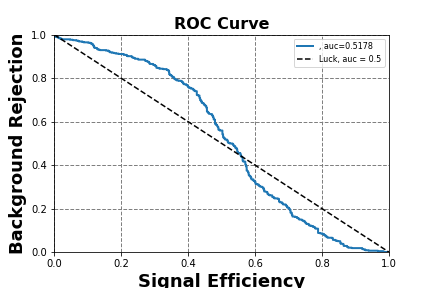

In [26]:
#display the roc curve
from IPython.display import Image
roc_image = glob.glob('logs/*.png')[0]
Image(filename=roc_image) 

In [45]:
# Now try customizing the loggers
# Let's say we want to save the log files in the directory my_logs
log_dir = 'my_logs'
# Let's say we want the file name format to be simply
filename = '{encoding_circuit}_{variational_circuit}_{n_qubit}_{time}'
# do not save npz file
save_npz = False
# do not save the model
save_weights = False
# do not save roc plot
roc_plot = False
# do not print logs unless fatal error messages
import logging
stream_level = logging.CRITICAL
# only save logs of level INFO or higher
file_level = logging.INFO
# only save the auc infos for the training results
keys = ['AUC', 'val_AUC', 'epoch']
logger = VQCLogger(log_dir=log_dir,filename=filename, keys=keys, stream_level=stream_level, file_level=file_level, save_npz=save_npz, save_weights=save_weights, roc_plot=roc_plot)

In [47]:
# Let's train again
vqc = VQC(encoding_circuit, variational_circuit, activation='sigmoid',
          optimizer=tf.keras.optimizers.Adam(), metrics=['binary_accuracy','AUC'], loss='mse',
          readout=[variational_circuit.readout_measurement()], trainable_dense_layer=False)
vqc.run(x_train, y_train, x_val, y_val, x_test, y_test, batch_size=64, epochs=100, callbacks=[logger])

Registered encoding circuit with feature dimension: 5
Registered variational circuit with number of parameters: 30
Converting circuits to tensors...
Converting circuits to tensors...


Train on 1000 samples, validate on 1000 samples
Epoch 1/100
1000/1000 [==============================] - 14s 14ms/sample - loss: 0.2492 - binary_accuracy: 0.6510 - AUC: 0.6212 - val_loss: 0.2488 - val_binary_accuracy: 0.6910 - val_AUC: 0.6730
Epoch 2/100
1000/1000 [==============================] - 14s 14ms/sample - loss: 0.2489 - binary_accuracy: 0.6830 - AUC: 0.6624 - val_loss: 0.2484 - val_binary_accuracy: 0.7020 - val_AUC: 0.7035
Epoch 3/100
1000/1000 [==============================] - 14s 14ms/sample - loss: 0.2485 - binary_accuracy: 0.6840 - AUC: 0.6884 - val_loss: 0.2481 - val_binary_accuracy: 0.6980 - val_AUC: 0.7421
Epoch 4/100
1000/1000 [==============================] - 14s 14ms/sample - loss: 0.2482 - binary_accuracy: 0.6790 - AUC: 0.7174 - val_loss: 0.2477 - val_binary_accuracy: 0.6930 - val_AUC: 0.7688
Epoch 5/100
1000/1000 [==============================] - 14s 14ms/sample - loss: 0.2479 - binary_accuracy: 0.6760 - AUC: 0.7430 - val_loss: 0.2474 - val_binary_accuracy: 0.

Converting circuits to tensors...


1000/1000 [==============================] - 1s 1ms/sample - loss: 0.2383 - binary_accuracy: 0.7070 - AUC: 0.8416
